In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import floor
from tqdm import tqdm
import os

## Helper functions

In [2]:
# get_img_intensity is a helper function to obtain the image intensity of an image 
# at a given coordinate if it exists
def get_img_intensity(img,x,y):
    assert len(img.shape)==2 # Checking if image shape is 2D
    # Checking if x and y are integers
    assert isinstance(x,int) 
    assert isinstance(y,int)
    if x<0 or x>=img.shape[0] or y<0 or y>=img.shape[1]:
        return 0
    else:
        return img[x,y]

# get_bilinear_interpolation_intensity takes source_image, x and y coordinates(possibly in decimals)
# and calculates intensity using Bilinear Interpolation from the image
def get_bilinear_interpolation_intensity(img_source,xs,ys):
    assert len(img_source.shape)==2
    xsd,ysd = int(floor(xs)),int(floor(ys))
    a,b = xs - xsd, ys - ysd
    return (1-a)*(1-b)*get_img_intensity(img_source,xsd,ysd) + \
           (a)*(1-b)*get_img_intensity(img_source,xsd+1,ysd) + \
           (1-a)*(b)*get_img_intensity(img_source,xsd,ysd+1) + \
           (a)*(b)*get_img_intensity(img_source,xsd+1,ysd+1)

## Solution

In [3]:
# sift_corresp is used to find corresponding points in two images
def sift_corresp(img1,img2):

    # Create a sift object
    sift = cv2.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

    # Feature matching using Brute Force Matcher
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)

    # Collecting all the matching keypoints from both images.
    # feat_match_1 containing all the points in img1 and feat_match_2 contains the 
    # corresponding matching points in img2
    feat_match_1 = [keypoints_1[mat.queryIdx].pt for mat in matches]
    feat_match_2 = [keypoints_2[mat.trainIdx].pt for mat in matches]
    return feat_match_1,feat_match_2


In [4]:
# compute_homography is a function to compute the homography matrix between two images

def compute_homography(img1,img2): 
    # Using SIFT to find all the point correspondences
    feat_match_1,feat_match_2 = sift_corresp(img1,img2)
    num_matches = len(feat_match_1)
    it = 0 
    max_n_consensus = 0
    max_H = None

    while True:
        it+=1
        # Choose 4 random points to compute homography matrix
        a = np.random.choice(num_matches, 4, replace=False)
        A = np.zeros((8,9))
        
        # Populate matrix A for all 4 points
        for i in range(4):
            (y1,x1) = feat_match_1[a[i]]
            (y1d,x1d) = feat_match_2[a[i]]
            A[2*i] = np.array([-x1,-y1,-1,0,0,0,x1*x1d,y1*x1d,x1d])
            A[2*i+1] = np.array([0,0,0,-x1,-y1,-1,x1*y1d,y1*y1d,y1d])
        
        # Find null(A) using SVD to find the homography matrix
        u,s,vh = np.linalg.svd(A)
        h = vh[-1]
        H = np.reshape(h,(3,3))

        # For the remaining points, checking if enough points satisfy homography(within the given error bound)
        n_consensus = 0
        for i in range(num_matches):
            if i in a:
                continue
            (y1,x1) = feat_match_1[i]
            (y1d,x1d) = feat_match_2[i]
            [x1dd,y1dd,z1dd] = H @ np.array([x1,y1,1])
            x1dd /= z1dd
            y1dd /= z1dd
            if np.sqrt((x1d-x1dd)**2 + (y1d-y1dd)**2) < 10: # homography satisfied
                n_consensus+=1
            if n_consensus > 0.8*num_matches: # number of points satisfying homography is above threshold
                return H
            else: # Keep track of the the homography matrix with maximum consensus
                if n_consensus>max_n_consensus:
                    max_n_consensus = n_consensus
                    max_H = H
        
        # If there are too many iterations, we return the homography matrix with 
        # the maximum consensus points till now
        if it > 10000:
            return max_H

    

In [5]:
# blend_values is a helper function to find the image intensity at a point in the mosaic image,
# given the image intensities obtained for that point from each of the component images.
# Here we simply take the average of all non zero intensities which lie in the image intensity range (0,255)
def blend_values(vals):
    tot = 0
    cnt = 0
    for v1 in vals:
        if v1>0 and v1<=255: 
            tot+=v1
            cnt+=1

    if cnt>0: return int(tot/cnt)
    else: return 0


# We assume one image as the base and stitch the rest of the images to that image. 
# The index of that image is indicated by base_image_index.
def compute_mosaic(imgs,base_image_index, canvas_size=(550,1400), offsetRow=80, offsetCol=300):
    allH = []
    # For each image, compute homography wrt the base image
    for i in range(len(imgs)):
        if i != base_image_index:
            allH.append(compute_homography(imgs[base_image_index], imgs[i]))
        else: # Homography of base image wrt itself is the identity matrix
            allH.append(np.identity(3))

    canvas = np.zeros(canvas_size)
    for ii in tqdm(range(canvas.shape[0])):
        for jj in range(canvas.shape[1]):
            # (i,j) is the coordinate of each point of canvas(ii,jj) in the base_image
            i = ii - offsetRow
            j = jj - offsetCol

            # vals contains all the image intensities of (ii,jj) obtained from all the images
            vals = []

            # Populate vals
            for imi in range(len(imgs)):
                tmp = allH[imi] @ np.array([i,j,1])
                x_i = tmp[0]/tmp[2]
                y_i = tmp[1]/tmp[2]
                vals.append(get_bilinear_interpolation_intensity(imgs[imi],x_i,y_i))

            # Use blend_values function to find the final image intensity at (ii,jj)
            canvas[ii,jj] = blend_values(vals)
    
    return canvas

100%|██████████| 550/550 [00:27<00:00, 19.65it/s]


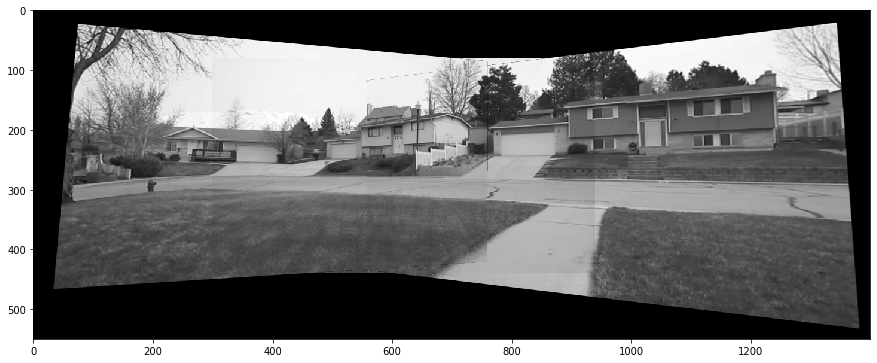

In [6]:
# Compute image mosaic for the given images

img1 = cv2.imread('img1.png',0)
img2 = cv2.imread('img2.png',0)
img3 = cv2.imread('img3.png',0)
canvas = compute_mosaic([img1,img2,img3],1)

# Plot the image canvas
plt.figure(figsize=(15,20))
plt.imshow(canvas,cmap = 'gray')
plt.savefig("image_mosaic.png")

The resulting image mosaic is quite good! Now, I will try to stitch some images taken from my mobile phone

## Capturing your own data


Here I have created a mosaic using 3 images taken at Manohar C Watsa stadium, IIT Madras


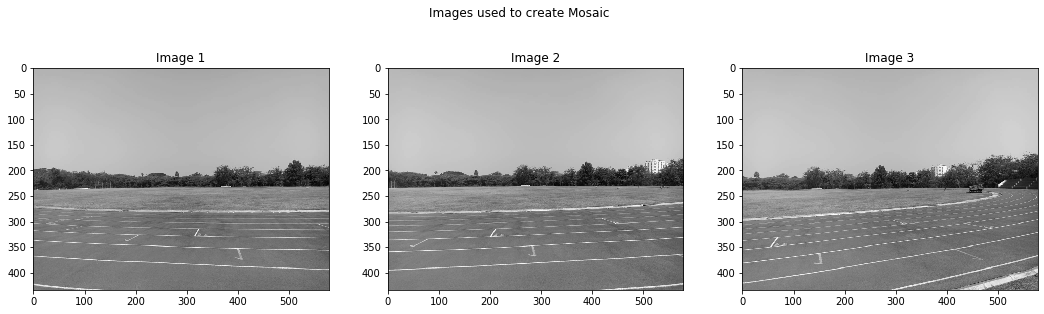

In [7]:

path = 'watsa_images'
pics = []
# Read all images in image directory and append them to the 'pics' list
for pc in sorted(os.listdir(path)):
    pics.append(cv2.imread(os.path.join(path, pc),0))

# Scaling by half to reduce number of computations
for i in range(len(pics)):
    scale = 0.5
    img = pics[i]
    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    dim = (width, height)
    pics[i] = cv2.resize(img, dim) # Resize

# Show the 3 images to be stitched together. These are also available in the watsa_images folder
f, axs = plt.subplots(1, 3, figsize = (18,5))
plt.suptitle("Images used to create Mosaic")
axs[0].set_title("Image 1")
axs[1].set_title("Image 2")
axs[2].set_title("Image 3")
axs[0].imshow(pics[0],cmap='gray')
axs[1].imshow(pics[1],cmap='gray')
axs[2].imshow(pics[2],cmap='gray')

100%|██████████| 650/650 [00:26<00:00, 24.55it/s]


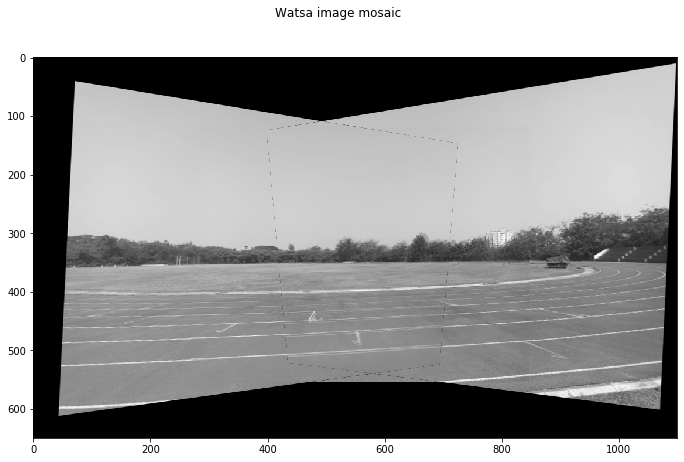

In [8]:
# Create the image mosaic from the 3 images shown above. 
# The optimal canvas size, offsetRow and offsetCol are found by trial and error,
# so that the final stitched image fully fits into the canvas size.
canvas = compute_mosaic(pics[:3],1, canvas_size=(650, 1100), offsetRow=120, offsetCol = 270)

# Plot the image canvas
plt.figure(figsize=(19,7))
plt.suptitle("Watsa image mosaic")
plt.imshow(canvas,cmap = 'gray')
plt.savefig("Watsa_image_mosaic.png")

The resulting image mosaic is also quite good. Thus we have successfully performed Image Mosaicing.